In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor

## Load Data

In [2]:
raw_df = pd.read_csv('data/train_house_price.csv')
raw_test = pd.read_csv('data/test_house_price.csv')
X_train = raw_df.iloc[:, :-1].copy()
y_train = raw_df.iloc[:, -1].copy()

## Split into Text or Numerical Features

In [3]:
def get_features(X_train):
    '''Remove columns with nulls and split into text or numerical features'''
    cols_w_nulls = X_train.columns[X_train.isnull().sum() > 0]
    features_txt = [i for i in X_train.dtypes[X_train.dtypes=='object'].index if i not in cols_w_nulls]
    features_num = [i for i in X_train.dtypes[(X_train.dtypes=='int') | (X_train.dtypes=='float')].index
                   if i not in cols_w_nulls]
    features_num.remove('Id')
    dummy_vars = OrdinalEncoder().fit(X_train[features_txt]).categories_
    dummy_vars = [np.hstack((i, 'Unknown')) for i in dummy_vars]
    return features_num, features_txt, dummy_vars
print([len(f) for f in get_features(X_train)])
# get_features(X_train)[2]

[33, 27, 27]


## Pipeline

In [4]:
def create_pipe(model, feature_tuple, ohe=False):
    '''Create scikit-learn pipeline'''
    features_num, features_txt, dummy_vars = feature_tuple
    if ohe:
        Encoder = OneHotEncoder
    else:
        Encoder = OrdinalEncoder
    ctx = ColumnTransformer([
        ('numbers', MinMaxScaler(), features_num),
        ('txt', Encoder(categories=dummy_vars), features_txt)
    ])
    model = Pipeline([
        ('preprocessor', ctx),
        ('model', model)])
    return model

class Stack_model(BaseEstimator):
    def fit(self, X, y):
        feature_names = get_features(X_train)
        ## models to stack
        lgbm = LGBMRegressor(max_depth=7, num_leaves=11, min_child_weight=40, min_child_samples=40)
        lr = LinearRegression()
        self.meta = LinearRegression(fit_intercept=False)
        ## 
        self.lgbm = create_pipe(lgbm, feature_names).fit(X, y)
        self.lr = create_pipe(lr, feature_names, ohe=True).fit(X, y)
        stacked_data = np.vstack((self.lgbm.predict(X), self.lr.predict(X))).T
        self.meta.fit(stacked_data, y)
    def predict(self, X):
        stacked_data = np.vstack((self.lgbm.predict(X), self.lr.predict(X))).T
        return self.meta.predict(stacked_data)

## Test Model

In [5]:
def test_model(model, X_train, y_train):
    '''Do cross-validation of model'''
    cv = KFold(n_splits=5, shuffle=True)
    cv_results = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, return_train_score=True)
    return pd.DataFrame(cv_results)

## Try Stacked Model

In [6]:
%%time
stack = Stack_model()
df_results = test_model(stack, X_train, y_train)
df_results

CPU times: user 10.5 s, sys: 1.02 s, total: 11.5 s
Wall time: 1.48 s


,fit_time,score_time,test_score,train_score
0,0.238836,0.022783,-17050.266242,-10354.036069
1,0.230381,0.022391,-13448.926217,-11429.990058
2,0.239734,0.022101,-16740.201911,-10671.315823
3,0.228980,0.022189,-14666.863241,-10935.092252
4,0.224801,0.045816,-16436.500830,-10806.890651


## Cleanup Test Dataset

In [7]:
feature_names = get_features(X_train)
num_cols, txt_cols, txt_cats = feature_names
X_test = raw_test.copy()
X_test[txt_cols] = X_test[txt_cols].fillna(value='Unknown')
for i in num_cols:
    X_test[i] = X_test[i].fillna(value=X_test[i].mean())

## Prediction

In [8]:
stack.fit(X_train, y_train)
print(stack.meta.coef_)
y_pred = stack.predict(X_test)
y_pred

[0.71542558 0.2885234 ]


array([122861.5016408 , 159990.8485299 , 181968.22178372, ...,
       173000.69564499, 118204.45318997, 229636.29193713])

In [9]:
def do_scatter(x, y, trend=True):
    '''scatter plot with optional trendline'''
    name = x.name
    if not trend:
        # categorical
        categories = feature_names[2][feature_names[1].index(name)]
        x = OrdinalEncoder([categories]).fit_transform(x.to_frame())
    sns.regplot(x, y, ci=None, color='C1', fit_reg=trend, scatter_kws={'alpha': .3})
    plt.xlabel(name)
    plt.ylabel('Price (£)')
    if not trend:
        # categorical
        plt.xticks(ticks=range(len(categories)), labels=categories, rotation=90)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

In [10]:
def do_subplots(column_name, trend=True):
    fig, ax = plt.subplots(1, 2, sharex=trend, sharey=True, figsize=(12, 4))
    plt.sca(ax[0])
    do_scatter(X_train[column_name], y_train, trend=trend)
    plt.title('Training Set')
    plt.sca(ax[1])
    do_scatter(X_test[column_name], y_pred, trend=trend)
    plt.title('Test Set Predictions')

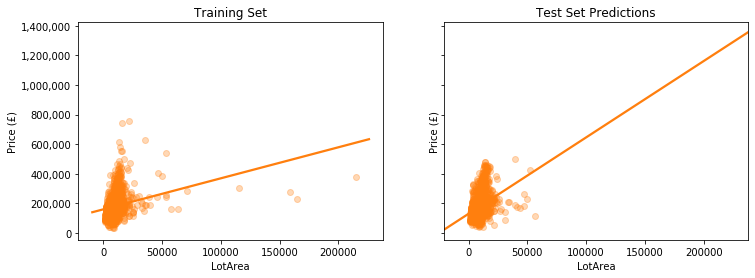

In [11]:
do_subplots('LotArea')

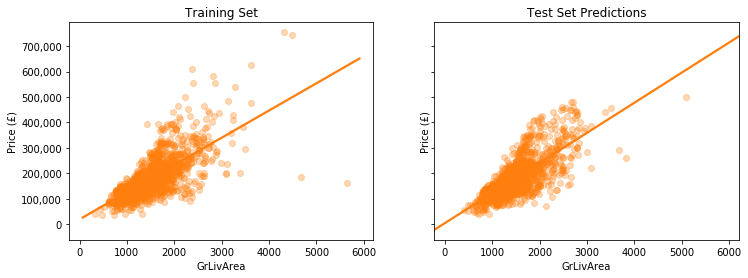

In [12]:
do_subplots('GrLivArea')

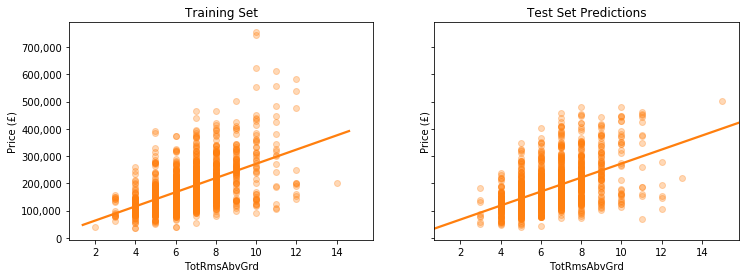

In [13]:
do_subplots('TotRmsAbvGrd')

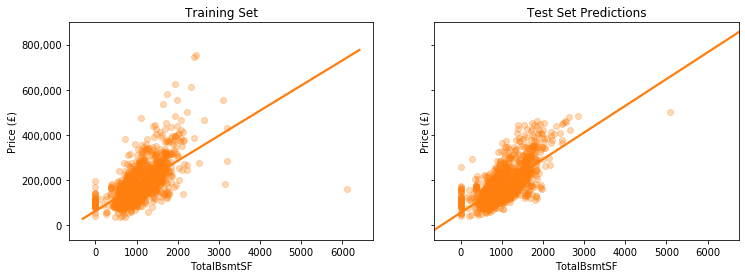

In [14]:
do_subplots('TotalBsmtSF')

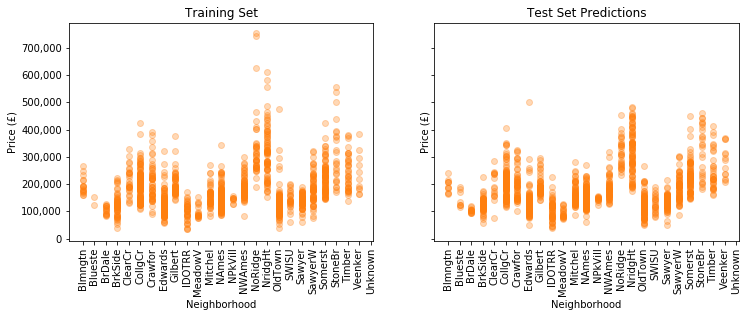

In [15]:
do_subplots('Neighborhood', trend=False)

In [16]:
print(y_pred[X_test['Neighborhood']=='StoneBr'].max())
print(y_train[X_train['Neighborhood']=='StoneBr'].max())

461789.44438405446
556581


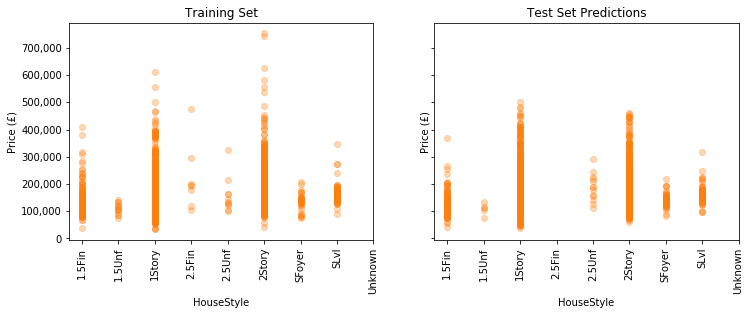

In [17]:
do_subplots('HouseStyle', trend=False)

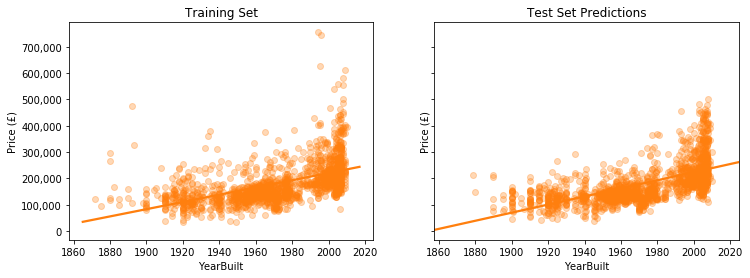

In [18]:
do_subplots('YearBuilt')